# HiRes-CESM Interactive Dashboard Example

Images created by this package can be visualized through an interactive
dashboard using [Panelify](https://github.com/andersy005/panelify)


In [1]:
import os

import pandas as pd
import panel as pn
import panelify
import yaml

pn.extension()

---

## Accessing the Data (Plots)

The plots from this example are stored on the
[CGD webext machine](https://webext.cgd.ucar.edu/), specifically from
[this specific case](https://webext.cgd.ucar.edu/g.e22.G1850ECO_JRA_HR.TL319_t13.004/),
which we use as the path. If running this notebook on glade, plots will come
from
`/glade/work/mlevy/hi-res_BGC_JRA/analysis/notebooks/images/g.e22.G1850ECO_JRA_HR.TL319_t13.004`.

We create a helper function which deals with reading in the image catalog, and
converting from relative filepaths to absolute filepaths


In [2]:
def read_dataframe(paths, relative_filepath=True):
    print(f"read_dataframe was provided {len(paths)} path(s)")
    if len(paths) > 1:
        df_list = []

        for path in paths:
            df = pd.read_csv(
                f"{path}png_catalog.csv"
            )  # .drop(columns="Unnamed: 0")

            # Convert the relative filepaths to absolute filepaths
            df["absolute_filepath"] = path + df.filepath.astype(str)

            df_list.append(df)

        # Merge the dataframes
        df = pd.concat(df_list)

    else:
        df = pd.read_csv(f"{paths[0]}png_catalog.csv")

        # Convert the relative filepaths to absolute filepaths
        df["absolute_filepath"] = paths[0] + df.filepath.astype(str)

    return df

### Dealing with Relative vs. Absolute Paths

In the previous cell, we edited the filepaths... that is because the image
filepaths in the `csv` file are relative paths, but we want to provide the
dashboard absolute paths. We make use of the dataframe path to assign the new
absolute filepaths.


---

### Build the Dashboard with Files on Glade or from webext

When running on glade, we build the dashboard using files from Mike Levy's
output
`/glade/work/mlevy/hi-res_BGC_JRA/analysis/notebooks/images/g.e22.G1850ECO_JRA_HR.TL319_t13.004/`.
If you ran the notebooks (ex. `plot_suite_004.ipynb`), and generated images in
the `images/` directory, you could use the relative path
`images/g.e22.G1850ECO_JRA_HR.TL319_t13.004`~

If you are not running with access to the files on glade, and do not opt to use
the local relative path, the dashboard will use case output available on CGD's
`webext` web server.


#### Once the path is setup, we can go ahead and check which types of plots are included in the analysis.


In [3]:
# Absolute path - use if you have NOT run the analysis notebooks
glade_root = os.path.join(
    os.path.sep,
    "glade",
    "work",
    "mlevy",
    "hi-res_BGC_JRA",
    "analysis",
    "notebooks",
    "images",
)

# To use local plots, uncomment the line below:
# glade_root = "images"

if os.path.isdir(glade_root):

    # This was left empty for glade as well, though the comment referenced https
    storage_options = {}
    print("Reading output from disk")
    paths = [os.path.join(glade_root, "g.e22.G1850ECO_JRA_HR.TL319_t13.004")]

else:
    print("Reading output from web")
    # Since we are using https, we leave this dictionary empty
    storage_options = {}
    paths = [
        "https://webext.cgd.ucar.edu/g.e22.G1850ECO_JRA_HR.TL319_t13.004/",
        "https://webext.cgd.ucar.edu/g.e22.G1850ECO_JRA_HR.TL319_t13.003/",
    ]

Reading output from web


In [4]:
df = read_dataframe(paths)
df.plot_type.unique()

read_dataframe was provided 2 path(s)


array(['histogram', 'summary_map', 'time_series', 'trend_hist',
       'trend_map'], dtype=object)

#### Adding plot types to the dashboard

Above, we see that there are 5 unique plot types defined in the data frame. Only
the data frames that are defined in `dashboard.yaml` are added to the dashboard.
Currently, that means the `trend_map` plots are not included (but the other four
are).

The cell below builds the dashboard from `dashboard.yaml` and then runs it in
the notebook.


Row
    [0] Tabs
        [0] ParamMethod(method, name='summary_map')
        [1] ParamMethod(method, name='time_series')
        [2] ParamMethod(method, name='histogram')
        [3] ParamMethod(method, name='trend_hist')
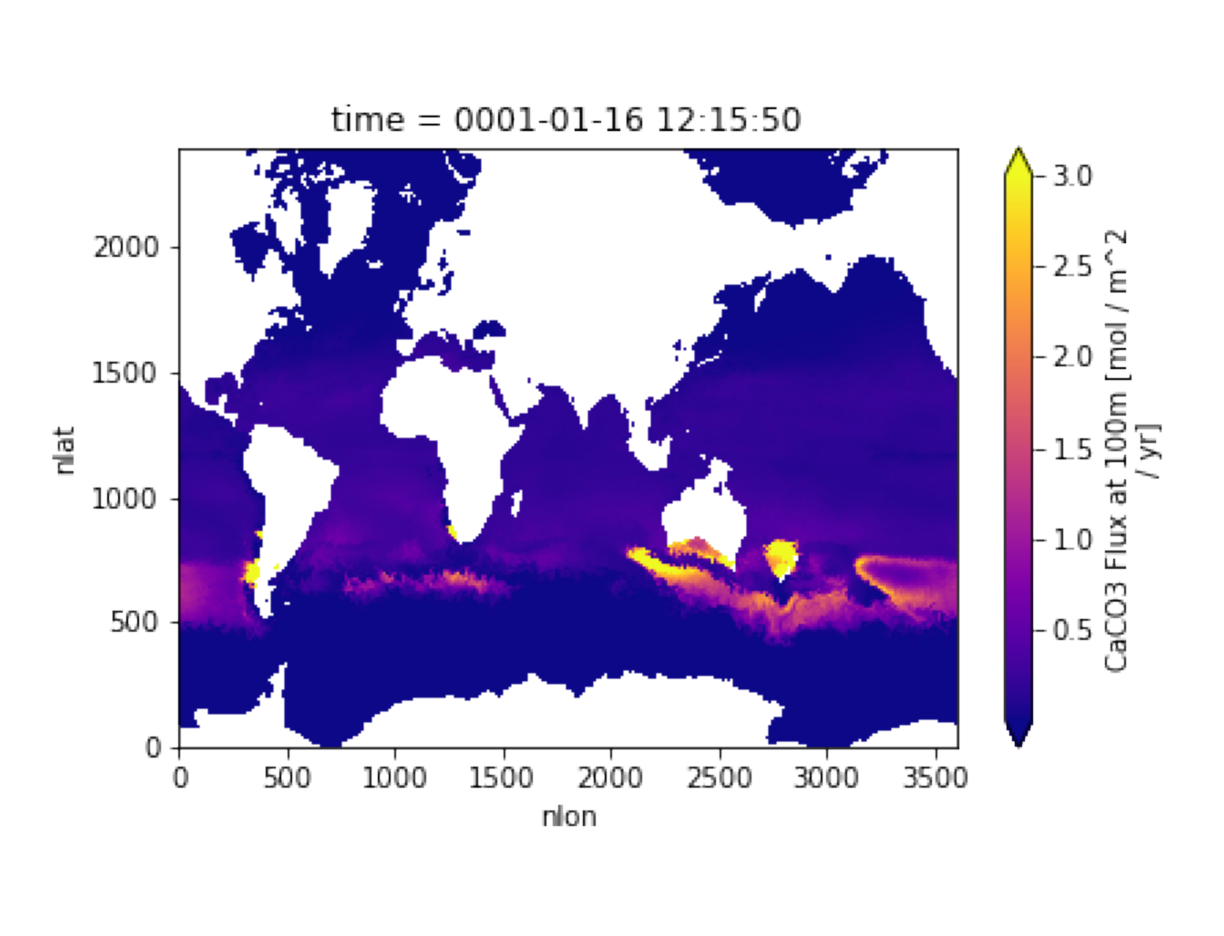
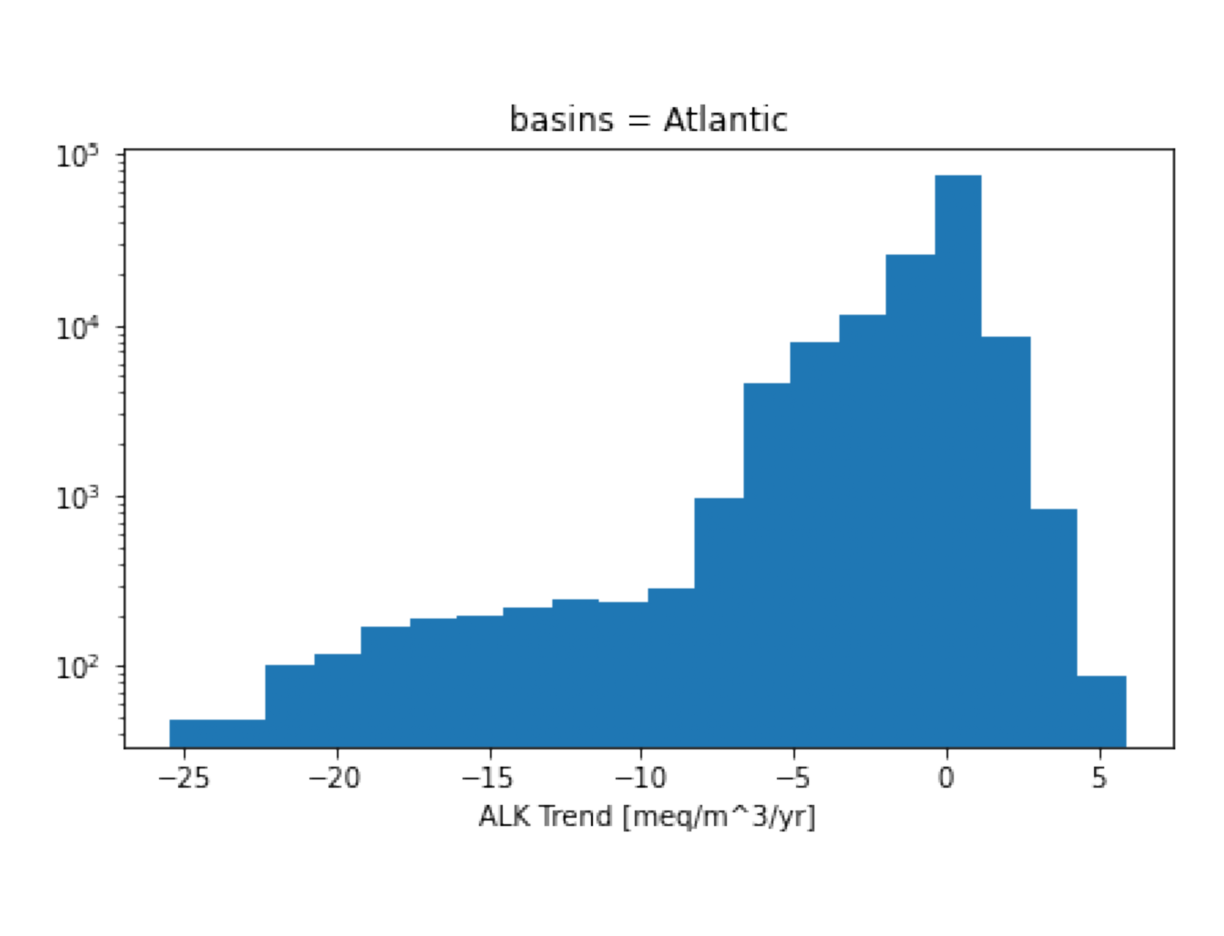
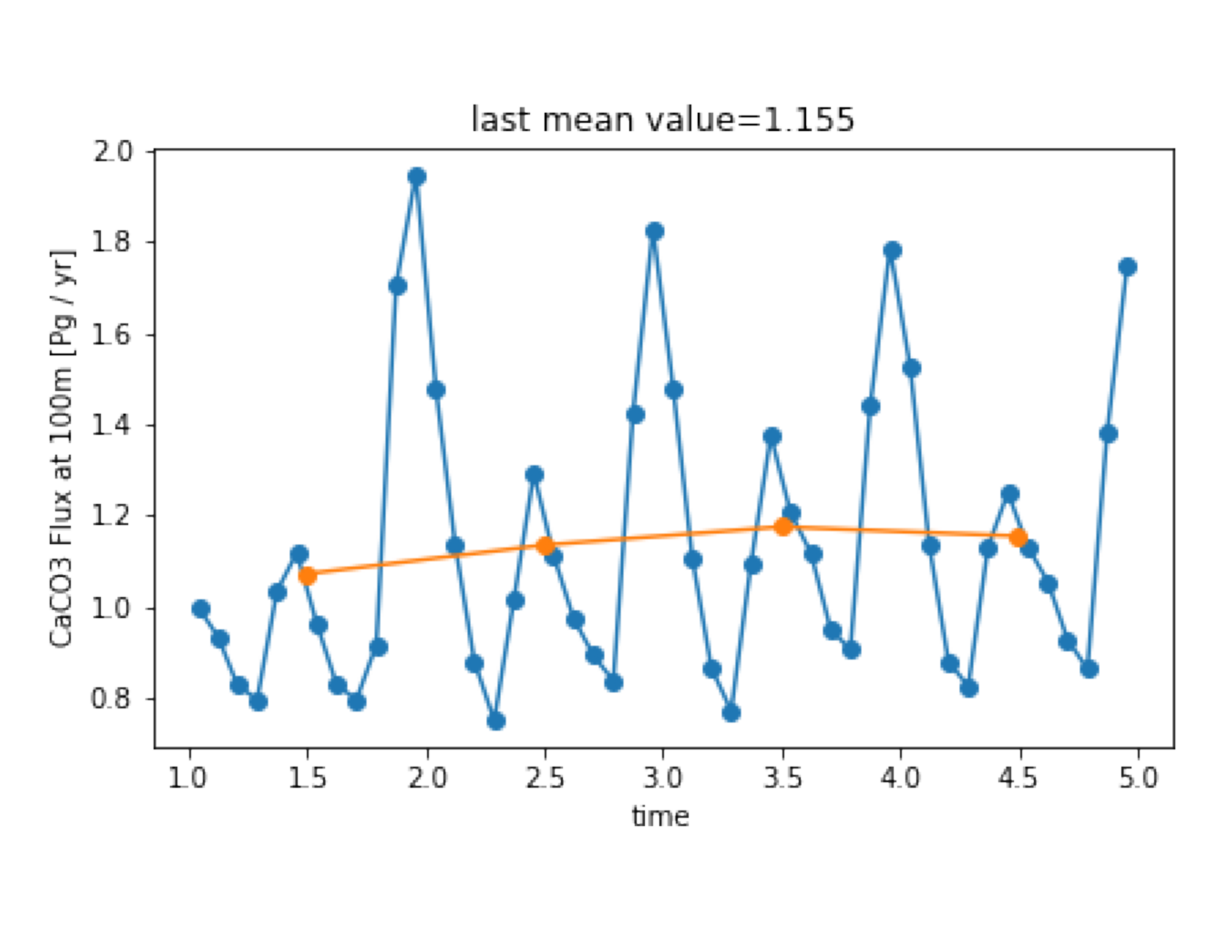
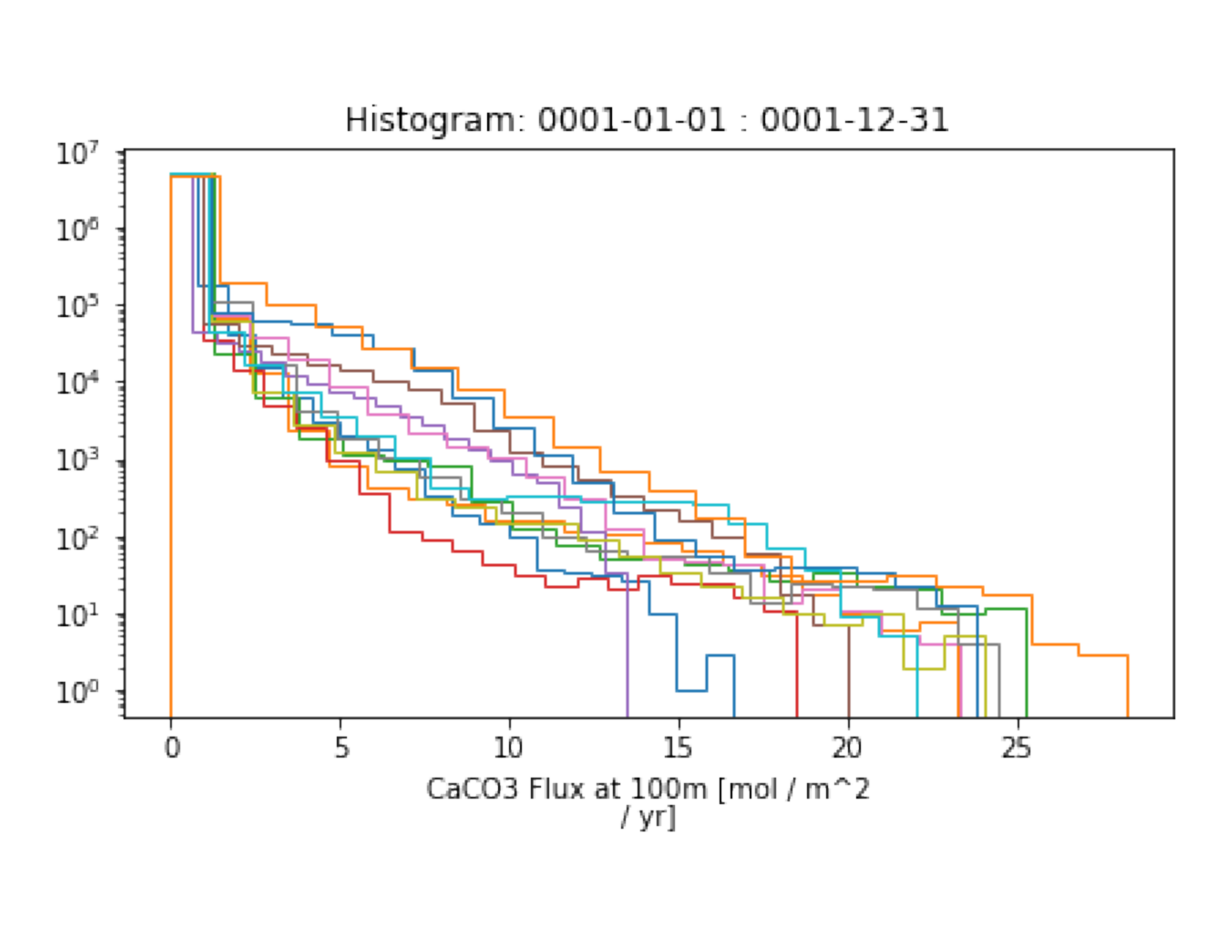

In [5]:
canvas_dict = {}

with open("dashboard.yaml") as yaml_file:
    panel_opts = yaml.safe_load(yaml_file)

# Create the timestep dashboard
for key, kwargs in panel_opts.items():
    canvas_dict[key] = panelify.create_dashboard(
        df=df.loc[df.plot_type == key],
        path_column="absolute_filepath",
        storage_options=storage_options,
        **kwargs
    ).view

dashboard = panelify.Canvas(canvas_dict).show()
dashboard.servable("HiRes-CESM Diagnostics Dashboard")